## Imports

In [37]:
import torch
import cv2
import numpy as np
import time

## Load_YoloV5_Model

In [38]:
# use GPU if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# load model structure from torch hub and use finetuned local weigts 
model = torch.hub.load('ultralytics/yolov5', 'custom', path='../yolov5/runs/train/exp/weights/best.pt', force_reload=True)

# set model device
model.to(device)

# # MIN confidence for truck detection
# model.conf = 0.4 

cuda:0


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\fatemeh/.cache\torch\hub\master.zip
YOLOv5  2023-9-7 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

## Detection_Image

(1024, 1280, 3)
Num of Trucks in Frame:  2


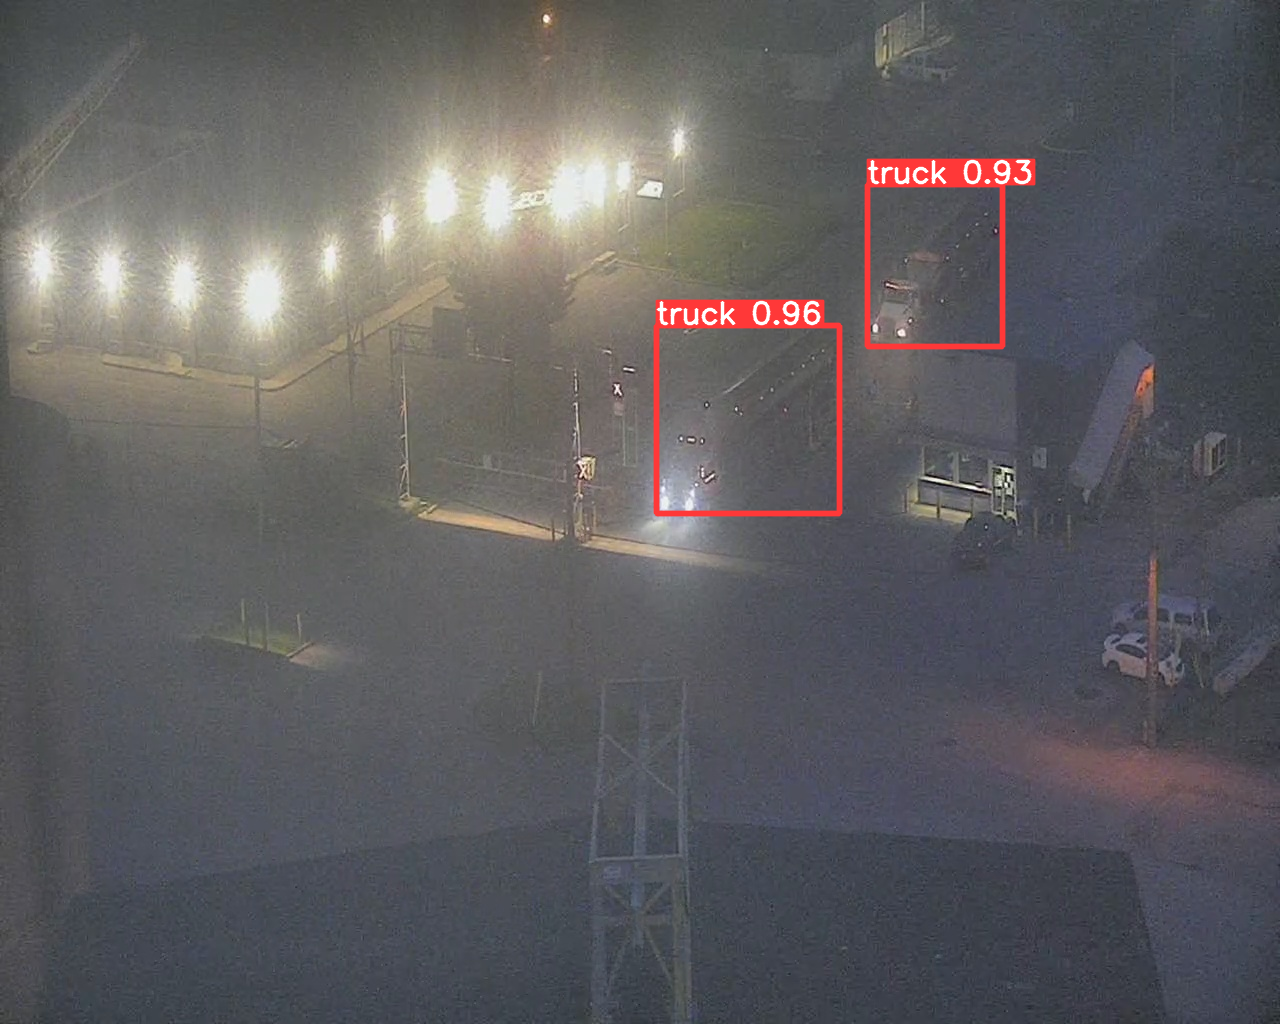

In [39]:
# Detection using finetuned Yolov5 for single frame
im = r'..\TruckDataset\images\val\time1_frame_142.jpg'

results = model(im)
result_img = np.squeeze(results.render())

cv2.putText(result_img, f'Yolov5 Model - truck: {results.xyxy[0].shape[0]}',(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

bgr_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

cv2.imshow('Image', bgr_img)

# Wait for a key press and then close the window
cv2.waitKey(0)
cv2.destroyAllWindows()

print(result_img.shape)
print('Num of Trucks in Frame: ', results.xyxy[0].shape[0])
results.show()

## Detection_Video_MultiTime

In [40]:
# Dictionary of different times
# a time have a start and end time 
# each of start and end time is a list: [h, m, s]
## you can comment some of times in dictinary if have short time

times = {'time1' : [[4, 56, 6], [4, 56, 30]],
         'time2' : [[5, 51, 33], [5, 53, 3]],
         'time3' : [[12, 4, 19], [12, 7, 0]],
         'time4' : [[15, 10, 10], [15, 10, 40]],
         'time5' : [[15, 21, 40], [15, 22, 26]],
         'time6' : [[16, 27, 23], [16, 28, 20]],
         'time7' : [[17, 24, 13], [17, 25, 0]],
         'time8' : [[18, 1, 30], [18, 2, 30]],
         'time9' : [[19, 14, 20], [19, 15, 13]]
         }
# times = {'time1' : [[4, 56, 6], [4, 58, 14]],
#          'time2' : [[5, 51, 33], [5, 53, 3]],
#          'time3' : [[6, 46, 22], [6, 43, 18]],
#          'time4' : [[7, 42, 41], [7, 43, 33]],
#          'time5' : [[12, 4, 19], [12, 15, 0]],
#          'time6' : [[15, 10, 10], [15, 10, 40]],
#          'time7' : [[15, 21, 40], [15, 22, 26]],
#          'time8' : [[16, 27, 23], [16, 28, 20]],
#          'time9' : [[17, 24, 13], [17, 25, 0]],
#          'time10' : [[18, 1, 30], [18, 2, 30]],
#          'time11' : [[19, 14, 20], [19, 16, 13]],
#          'time12' : [[20, 45, 20], [20, 47, 38]],
#          'time13' : [[20, 56, 0], [20, 57, 0]],
#          'time14' : [[21, 52, 45], [21, 53, 45]],
#          'time15' : [[23, 24, 30], [23, 25, 10]],
#          'time16' : [[20, 25, 40], [20, 21, 30]]
#          }

In [41]:
model.eval()

cap = cv2.VideoCapture(r"..\..\Data\TruckVideo.mp4")

#output video setting
output_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
output_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('output_width', output_width)
print('output_height', output_height)

output_fps = cap.get(cv2.CAP_PROP_FPS) 
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Use 'mp4v' codec for MP4 format

output_path = 'Yolov5_annotated.mp4'

out = cv2.VideoWriter(output_path, fourcc, output_fps, (output_width, output_height))

time_step = 1

#truck detection in different times
## use esc+q to switch between times
for t in times.keys():
    start_time = times[t][0][0] * 3600 + times[t][0][1] * 60  + times[t][0][2]# Convert start time to seconds
    end_time = times[t][1][0] * 3600 + times[t][1][1] * 60  + times[t][1][2] # Convert end time to seconds

    # set start time for captured video
    cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

    frame_time = start_time
    
    # truck detection for time t
    while frame_time <= end_time:
        ret, frame = cap.read()
        
        if not ret:
            break

        # use model for detection
        with torch.no_grad():
            results = model(frame)

        annotated_frame = np.squeeze(results.render())

        # write number of trucks on frame
        cv2.putText(annotated_frame,f'Yolov5 Model - truck: {results.xyxy[0].shape[0]}',(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            
        # add frame to video
        #output image shape:  (1024, 1280, 3) but our video shape is: (1280, 1024, 3)
        resized_frame = cv2.resize(annotated_frame, (annotated_frame.shape[1], annotated_frame.shape[0]))
        out.write(resized_frame)
        
        # display annotated frame 
        cv2.imshow('YOLOV5', annotated_frame)

        frame_time += time_step

        # update capture start_time
        cap.set(cv2.CAP_PROP_POS_MSEC, frame_time * 1000)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break       

out.release()        
cap.release()
cv2.destroyAllWindows()

output_width 1280
output_height 1024


## Detection_Video_SingleTime

In [42]:
model.eval()

cap = cv2.VideoCapture(r"..\..\Data\TruckVideo.mp4")

# define start time of video for detection (secounds)
## press esc+q to stop detection
start_time = 4 * 3600 + 56 * 60  + 2

# set start time for captured video
cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

frame_time = start_time
frame_count = 0
current_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break
    
    # use model for detection
    with torch.no_grad():
        results = model(frame)

    annotated_frame = np.squeeze(results.render())

    cv2.putText(annotated_frame,f'Yolov5 Model - truck: {results.xyxy[0].shape[0]}',(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
    
    # display annotated frame
    cv2.imshow('YOLOV5', annotated_frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()